In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch  
from scipy.ndimage import gaussian_filter1d

plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'svg.fonttype': 'none',
    'figure.titlesize': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'ytick.labelsize': 6,
    'xtick.labelsize': 6,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

In [2]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [3]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#4daf4a',    # Green
    'paranoia_light': '#90ee90', # Light green
    'combined': '#984ea3',    # Purple
    'combined_light': '#d8b2d8' # Light purple
}

In [4]:
SAVE_DIR_FIG4 = Path(SAVE_DIR) / "figure4"
SAVE_DIR_FIG4.mkdir(parents=True, exist_ok=True)

In [5]:
def save_figure(fig, save_dir, filename, dpi=300, bbox_inches='tight'):
    # Remove any existing file extension from the filename
    base_filename = Path(filename).stem
    
    # Save both PNG and SVG versions
    fig.savefig(Path(save_dir) / f'{base_filename}.png', dpi=dpi, bbox_inches=bbox_inches)
    fig.savefig(Path(save_dir) / f'{base_filename}.svg', dpi=dpi, bbox_inches=bbox_inches)
    plt.close(fig)

## P1-1 - primary brain state time series

In [6]:
# Load the saved results
with open(OUTPUT_DIR / "09_group_HMM_comparison" / "comparisons.pkl", 'rb') as f:
    comp_results = pickle.load(f)

In [26]:
def plot_temporal_dynamics(results, pairs='state_pair_0_0'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 1.5), sharex=True)
    profile = results['temporal_dynamics'][pairs]['temporal_profile']
    

    # Plot affair profile
    ax.plot(profile['affair_profile'],
            color=COLORS['affair'],
        #     label='Affair',
            linewidth=1)
    
    # Plot paranoia profile
    ax.plot(profile['paranoia_profile'],
            color=COLORS['paranoia'],
        #     label='Paranoia ',
            linewidth=1)
    
    ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_xlabel('Time (TRs)')
    
    # ax.set_ylabel('State Probability')
    # ax.legend()
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    
    # Make x-axis start from 0
    max_length = max(len(profile['affair_profile']), len(profile['paranoia_profile']))
    ax.set_xlim(0, max_length - 1)

    plt.tight_layout()
    plt.show()
    save_figure(fig, SAVE_DIR_FIG4, f'group_temporal_dynamics_{pairs}')
    
    plt.close()

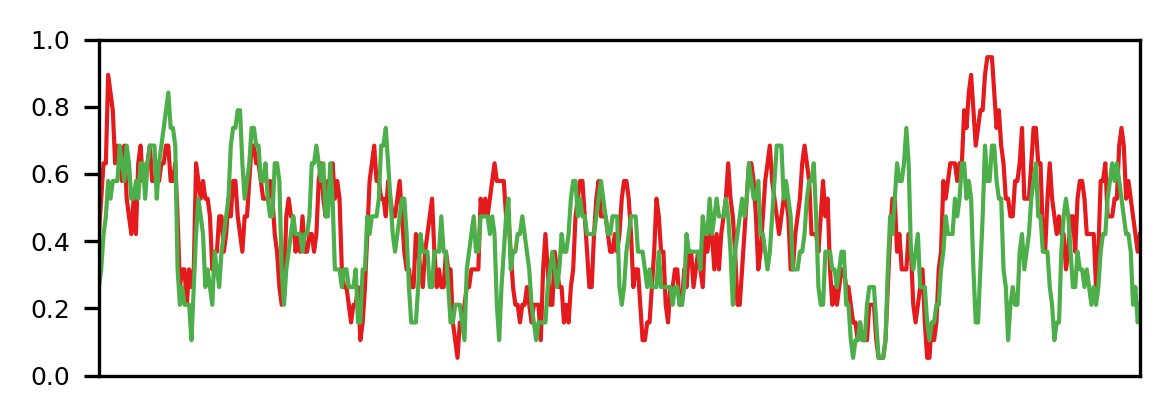

In [27]:
plot_temporal_dynamics(comp_results)

## P1-2 - content feature

In [19]:
def create_tr_raster_plot(annotations_file: str, save_path: str, label: bool = False) -> plt.Figure:
    """Create raster plot of story features at TR level."""
    # Read data
    df = pd.read_csv(annotations_file)
    
    # Filter to only include features that exist in the dataframe
    binary_features = ['is_dialog', 'arthur_speaking', 'lee_speaking', 
                       'girl_speaking', 'lee_girl_together', 'has_verb', 
                       'has_noun', 'has_adj', 'has_adv']
    binary_features = sorted(binary_features)
 
    # Create figure with single plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    
    # Colors for binary features (use only as many as needed)
    colors = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', 
             '#F39B7F', '#8491B4', '#91D1C2', '#DC0000', '#7E6148']
    
    # Plot binary features
    for idx, (feature, color) in enumerate(zip(binary_features, colors)):
        mask = df[feature].astype(bool)
        if mask.any():
            ax.vlines(df.loc[mask, 'adjusted_onset_TR'], 
                      idx - 0.2, idx + 0.2,
                      color=color, linewidth=1)
    
    # Customize binary features plot
    ax.set_xticks([])
    if label:
        # ax.set_yticks([])
        ax.set_yticks(range(len(binary_features)))
        ax.set_yticklabels([f.replace('_', ' ').title() for f in binary_features])
        save_path = save_path + '_label'
    else:
        ax.set_yticks([])
        save_path = save_path + '_nolabel'
    
    ax.set_xlim(0, df['adjusted_onset_TR'].max())
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.set_xlabel('Time (TR)')
    # ax.set_title('Story Features', pad=10)
    
    plt.tight_layout()
    plt.savefig(SAVE_DIR_FIG4 / f'{save_path}.png', dpi=300, bbox_inches='tight')
    plt.savefig(SAVE_DIR_FIG4 / f'{save_path}.svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [15]:
data_dir = os.path.join(scratch_dir, 'data', 'stimuli')
content_file = Path(data_dir) / "10_story_annotations_TR.csv"

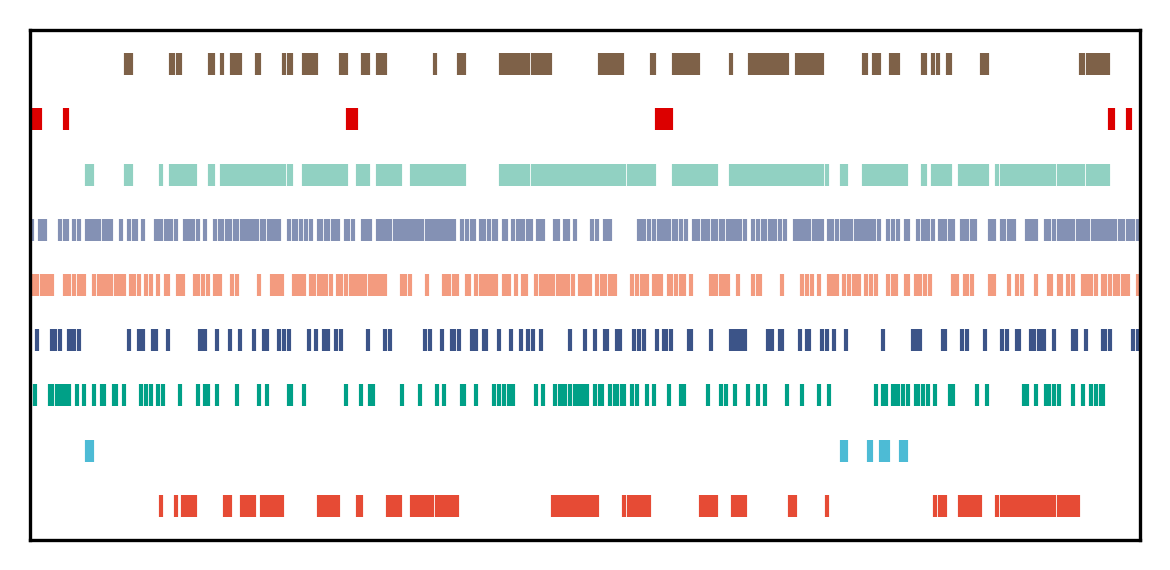

In [21]:
create_tr_raster_plot(content_file, 'content_tr_raster_plot', label=False)

## P1-3 - behavior data

In [28]:
affair_beh_file = Path(OUTPUT_DIR) / 'behav_results' / 'individual_response_evidence_affair.pkl'
paranoia_beh_file = Path(OUTPUT_DIR) / 'behav_results' / 'individual_response_evidence_paranoia.pkl'
affair_beh_data = pickle.load(open(affair_beh_file, 'rb'))
paranoia_beh_data = pickle.load(open(paranoia_beh_file, 'rb'))

In [29]:
def safe_eval_response(response, offset=14, n_timepoints=451):
    """
    Safely handle response data with time shift.
    
    Parameters:
    -----------
    response : array-like
        Response data
    offset : int
        Number of TRs to discard from start
    n_timepoints : int
        Total number of timepoints to keep
    """
    if isinstance(response, np.ndarray):
        data = response[offset:offset+n_timepoints]
    elif isinstance(response, list):
        data = np.array(response[offset:offset+n_timepoints])
    else:
        raise ValueError(f"Unexpected response type: {type(response)}")
    
    return data

In [30]:
def plot_behavioral_responses(affair_data, paranoia_data, offset=14, n_timepoints=451):
    """
    Create visualization of behavioral responses with both groups in a single plot,
    including individual participant responses as jittered dots.
    
    Parameters:
    -----------
    affair_data : pd.DataFrame
        DataFrame containing affair group responses
    paranoia_data : pd.DataFrame
        DataFrame containing paranoia group responses
    offset : int
        Number of TRs to discard from start
    n_timepoints : int
        Total number of timepoints to keep after offset
    """
    # Create figure with single plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    
    # Set up time points (starting at 0 after offset)
    time_points = np.arange(n_timepoints)
    
    # Process affair group
    affair_responses = []
    
    # Define jitter range - use most of the plot height
    # Leave some space at top and bottom for the lines to be visible
    jitter_range = 0.4  # This will spread dots across most of the 0-0.5 y-axis range
    
    for idx, row in enumerate(affair_data.iterrows()):
        try:
            # Get response data with offset
            response = np.array(row[1]['binary_response'])[offset:offset+n_timepoints]
            affair_responses.append(response)
            
            # Plot individual responses as dots with jitter
            response_times = np.where(response == 1)[0]
            # Add random jitter to y-position
            jitter = np.random.uniform(0.05, jitter_range, size=len(response_times))
            ax.scatter(response_times, 
                      jitter,  # Spread across the plot
                      color=COLORS['affair_light'], alpha=0.2, s=1)
            
        except Exception as e:
            print(f"Error processing affair participant {idx}: {str(e)}")
            continue
    
    # Calculate and plot average for affair group
    if affair_responses:
        affair_responses = np.array(affair_responses)
        affair_avg = affair_responses.mean(axis=0)
        affair_avg_smooth = gaussian_filter1d(affair_avg, sigma=2)
        ax.plot(time_points, affair_avg_smooth, color=COLORS['affair'], linewidth=1.5, label='Affair')
    
    # Process paranoia group
    paranoia_responses = []
    
    for idx, row in enumerate(paranoia_data.iterrows()):
        try:
            # Get response data with offset
            response = np.array(row[1]['binary_response'])[offset:offset+n_timepoints]
            paranoia_responses.append(response)
            
            # Plot individual responses as dots with jitter
            response_times = np.where(response == 1)[0]
            # Add random jitter to y-position
            jitter = np.random.uniform(0.05, jitter_range, size=len(response_times))
            ax.scatter(response_times, 
                      jitter,  # Spread across the plot
                      color=COLORS['paranoia_light'], alpha=0.2, s=1)
            
        except Exception as e:
            print(f"Error processing paranoia participant {idx}: {str(e)}")
            continue
    
    # Calculate and plot average for paranoia group
    if paranoia_responses:
        paranoia_responses = np.array(paranoia_responses)
        paranoia_avg = paranoia_responses.mean(axis=0)
        paranoia_avg_smooth = gaussian_filter1d(paranoia_avg, sigma=2)
        ax.plot(time_points, paranoia_avg_smooth, color=COLORS['paranoia'], linewidth=1.5, label='Paranoia')
    
    # Customize plot
    ax.set_ylim(0, 0.4)  # Adjust as needed
    ax.set_xlim(0, n_timepoints-1)  # Set x-axis to match data length
    
    # Add labels
    # ax.set_ylabel('Response Probability')
    # ax.set_xlabel('Time (TRs)')
    
    # Add x-axis ticks every 50 TRs
    tick_interval = 50
    ax.set_xticks(np.arange(0, n_timepoints, tick_interval))
    
    # Add legend
    # ax.legend(loc='upper right')
    
    # Remove top and right spines
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    # Save figure
    save_figure(fig, SAVE_DIR_FIG4, 'behavioral_responses_combined')
    plt.close()

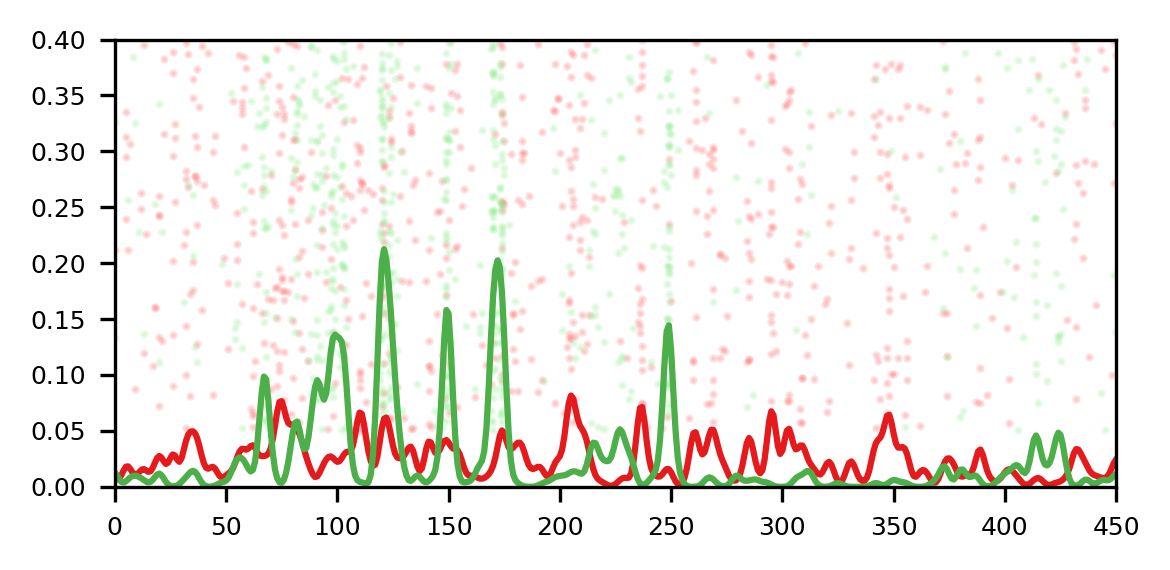

In [31]:
plot_behavioral_responses(affair_beh_data, paranoia_beh_data)

## P2 - brain-content analysis

In [45]:
def plot_brain_state_effects(main_analysis, use_cohens_d=True, save_path=None, figsize=(1.5, 4), label=False):
    """Create figure showing content feature effects with consistent metrics
    
    Parameters:
    -----------
    main_analysis : numpy.ndarray or dict
        Array containing the analysis results data structure
    use_cohens_d : bool
        If True, use standardized effect size as x-axis metric; if False, use log odds coefficients
    save_path : str, optional
        Path to save the figure
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure with brain state effects plots
    """
    # Convert numpy array to dictionary
    if isinstance(main_analysis, np.ndarray):
        results_dict = main_analysis.item()
    else:
        results_dict = main_analysis
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Get features from the feature_results dictionary
    features = list(results_dict['feature_results'].keys())
    
    plot_features = sorted(features)

    # Prepare data for Affair group
    affair_data = {
        'feature': plot_features
    }

    if use_cohens_d:
        # For standardized effect, use the values from effect_sizes
        affair_data['effect'] = [results_dict['effect_sizes'][f]['standardized_effect'] for f in plot_features]
        x_label = "Effect Size (Standardized)"
    else:
        # For log odds ratio, use the odds_ratio values
        affair_data['effect'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['odds_ratio']) for f in plot_features]
        x_label = "Log Odds Ratio"
    
    # Add credible intervals and probability
    if use_cohens_d:
        # Use HDI for standardized effect
        affair_data['ci_lower'] = [results_dict['feature_results'][f]['hdi']['group']['lower'] for f in plot_features]
        affair_data['ci_upper'] = [results_dict['feature_results'][f]['hdi']['group']['upper'] for f in plot_features]
    else:
        # For log odds ratio, transform the HDI to log scale
        affair_data['ci_lower'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['lower']) for f in plot_features]
        affair_data['ci_upper'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['upper']) for f in plot_features]
    
    # Use posterior_prob instead of prob_nonzero
    affair_data['probability'] = [results_dict['feature_results'][f]['posterior_prob']['group'] for f in plot_features]
    
    # Prepare data for Paranoia group (effect + interaction)
    paranoia_data = {
        'feature': plot_features
    }

    print(plot_features)
    
    # Get combined effects for paranoia group
    if use_cohens_d:
        # This is approximate since we don't have direct standardized effect for combined effects
        paranoia_data['effect'] = [results_dict['effect_sizes'][f]['standardized_effect'] * 
                                (1 + results_dict['feature_results'][f]['coefficients']['interaction'] / 
                                results_dict['feature_results'][f]['coefficients']['group'])
                                for f in plot_features]
    else:
        # For log odds ratio, calculate combined effect (group + interaction)
        paranoia_data['effect'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['odds_ratio'] * 
                                   results_dict['feature_results'][f]['odds_ratios']['interaction']['odds_ratio'])
                                   for f in plot_features]
    
    # Add credible intervals and probability for paranoia
    if use_cohens_d:
        # For paranoia with standardized effect, we need to add the HDIs
        paranoia_data['ci_lower'] = [results_dict['feature_results'][f]['hdi']['group']['lower'] +
                                    results_dict['feature_results'][f]['hdi']['interaction']['lower']
                                    for f in plot_features]
        paranoia_data['ci_upper'] = [results_dict['feature_results'][f]['hdi']['group']['upper'] +
                                    results_dict['feature_results'][f]['hdi']['interaction']['upper']
                                    for f in plot_features]
    else:
        # For log odds ratio, calculate the combined CI for group + interaction
        # This is an approximation using the product of the odds ratios
        paranoia_data['ci_lower'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['lower'] * 
                                         results_dict['feature_results'][f]['odds_ratios']['interaction']['lower'])
                                     for f in plot_features]
        paranoia_data['ci_upper'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['upper'] * 
                                         results_dict['feature_results'][f]['odds_ratios']['interaction']['upper'])
                                     for f in plot_features]
    
    paranoia_data['probability'] = [results_dict['feature_results'][f]['posterior_prob']['interaction'] 
                                    for f in plot_features]
    
    # Convert to DataFrames
    df_affair = pd.DataFrame(affair_data)
    df_paranoia = pd.DataFrame(paranoia_data)
    
    # Define group colors
    affair_color = COLORS['affair']    # Red
    paranoia_color = COLORS['paranoia']  # Blue
    
    # Helper function for color adjustment
    def adjust_color_alpha(color, alpha_factor):
        """Adjust the alpha/intensity of a color"""
        rgb = plt.cm.colors.ColorConverter.to_rgb(color)
        return tuple([c * alpha_factor + (1-alpha_factor) for c in rgb])
    
    # Function to plot one group
    def plot_group(ax, df, title, group_color, is_bottom=False, label=False):
        # Create color variants for probability levels
        color_high = group_color
        color_med = adjust_color_alpha(group_color, 0.7)
        color_low = adjust_color_alpha(group_color, 0.4)
        gray_color = '#777777'
        
        # Determine color based on posterior probability AND CI crossing zero
        colors = []
        for _, row in df.iterrows():
            # Check if CI crosses zero - stricter condition
            ci_crosses_zero = (row['ci_lower'] < 0 and row['ci_upper'] > 0)
            
            # Get the appropriate probability value
            prob = row['probability']
            
            # Print debug info
            # print(f"Feature: {row['feature']}, Effect: {row['effect']:.4f}, CI: [{row['ci_lower']:.4f}, {row['ci_upper']:.4f}], Prob: {prob:.4f}, CI crosses 0: {ci_crosses_zero}")
            
            # Only assign probability color if CI doesn't cross zero
            if not ci_crosses_zero:
                if prob > 0.999:
                    colors.append(color_high)
                elif prob > 0.99:
                    colors.append(color_med)  
                elif prob > 0.95:
                    colors.append(color_low)
                else:
                    colors.append(gray_color)
            else:
                colors.append(gray_color)
        
        # Calculate y-positions
        y_pos = np.arange(len(df))
        
        # Find appropriate axis limits
        all_values = list(df['effect']) + list(df['ci_lower']) + list(df['ci_upper'])
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Add padding
        padding = 0.1 * (max_val - min_val)
        x_min = min_val - padding
        x_max = max_val + padding
        
        # Ensure zero is visible if it's close to the range
        if min_val > -padding and min_val < 0:
            x_min = -padding
        if max_val < padding and max_val > 0:
            x_max = padding
            
        # Plot reference line at zero
        ax.axvline(x=0, color='gray', linestyle='-', alpha=0.7, linewidth=0.5)
        
        # Plot data points and intervals
        for i, (_, row) in enumerate(df.iterrows()):
            # Plot CI line
            ax.hlines(y=y_pos[i], xmin=row['ci_lower'], xmax=row['ci_upper'], 
                     color=colors[i], alpha=0.6, linewidth=1)
            
            # Plot point
            ax.scatter(row['effect'], y_pos[i], color=colors[i], s=5, zorder=3)
        
        if label:
            ax.set_yticks(y_pos)
            ax.set_yticklabels([f.replace('_', ' ').title() for f in df['feature']])
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])

        if is_bottom:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("")
        
        ax.set_title(title)
        
        # # Set axis limits
        # ax.set_xlim(x_min, x_max)
        # ax.set_ylim(-0.5, len(df) - 0.5)
        
        # Add grid
        ax.grid(axis='x', linestyle=':', alpha=0.3)
        
        # Add legend with only elements that appear in the plot
        from matplotlib.lines import Line2D
        
        # Create sets to track which probability levels are used
        has_high_prob = any(c == color_high for c in colors)
        has_med_prob = any(c == color_med for c in colors)
        has_low_prob = any(c == color_low for c in colors)
        has_gray = any(c == gray_color for c in colors)
        
        # Only include legend elements that are present in the plot
        legend_elements = []
        if has_high_prob:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color_high,
                                label='>99.9% probability', markersize=2))
        if has_med_prob:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color_med,
                                label='>99% probability', markersize=2))
        if has_low_prob:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color_low,
                                label='>95% probability', markersize=2))
        if has_gray:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=gray_color,
                                label='<95% probability or CI crosses 0', markersize=2))
        
        # Only add legend if there are elements to show
        # if legend_elements:
        #     ax.legend(handles=legend_elements, loc='best')
    
    # Calculate global min and max for consistent x-axis scaling
    all_affair_values = list(df_affair['effect']) + list(df_affair['ci_lower']) + list(df_affair['ci_upper'])
    all_paranoia_values = list(df_paranoia['effect']) + list(df_paranoia['ci_lower']) + list(df_paranoia['ci_upper'])
    all_values = all_affair_values + all_paranoia_values
    
    global_min = min(all_values)
    global_max = max(all_values)
    
    # Add padding
    padding = 0.1 * (global_max - global_min)
    global_x_min = global_min - padding
    global_x_max = global_max + padding
    
    # Ensure zero is visible if it's close to the range
    if global_min > -padding and global_min < 0:
        global_x_min = -padding
    if global_max < padding and global_max > 0:
        global_x_max = padding

    # Plot both groups
    plot_group(ax1, df_affair, '', affair_color, is_bottom=False, label=label)
    plot_group(ax2, df_paranoia, '', paranoia_color, is_bottom=True, label=label)
    
    # Set the same x-axis limits for both plots
    ax1.set_xlim(global_x_min, global_x_max)
    ax2.set_xlim(global_x_min, global_x_max)
    
    # Set y-axis limits
    ax1.set_ylim(-0.5, len(df_affair) - 0.5)
    ax2.set_ylim(-0.5, len(df_paranoia) - 0.5)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    if save_path and label:
        plt.savefig(SAVE_DIR_FIG4 / f'{save_path}_label.png', dpi=300, bbox_inches='tight')
        plt.savefig(SAVE_DIR_FIG4 / f'{save_path}_label.svg', dpi=300, bbox_inches='tight')
    elif save_path and not label:
        plt.savefig(SAVE_DIR_FIG4 / f'{save_path}_nolabel.png', dpi=300, bbox_inches='tight')
        plt.savefig(SAVE_DIR_FIG4 / f'{save_path}_nolabel.svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [34]:
state_map = {"affair_to_paranoia": {0:1, 1:2, 2:0}, "paranoia_to_affair": {1:0, 2:1, 0:2}}

In [35]:
def get_brain_content_data(state_affair, state_paranoia):
    # Use Path.glob() method instead of glob module
    pattern = f'hierarchical_analysis_results_*.npz'
    search_path = Path(OUTPUT_DIR) / '11_brain_content_analysis' / f'state_affair_{state_affair}_state_paranoia_{state_paranoia}'
    brain_content_path = list(search_path.glob(pattern))[0]
    brain_content_data = np.load(brain_content_path, allow_pickle=True)
    meta_data = brain_content_data['metadata']
    main_analysis = brain_content_data['main_analysis']
    cross_validation = brain_content_data['cross_validation']
    return meta_data, main_analysis, cross_validation

In [36]:
state_affair = 0
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a0p1 , main_analysis_a0p1, cross_validation_a0p1 = get_brain_content_data(state_affair, state_paranoia)
state_affair = 1
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a1p2, main_analysis_a1p2, cross_validation_a1p2 = get_brain_content_data(state_affair, state_paranoia)
state_affair = 2
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a2p0, main_analysis_a2p0, cross_validation_a2p0 = get_brain_content_data(state_affair, state_paranoia)

['arthur_adj', 'arthur_speaking', 'girl_speaking', 'has_adj', 'has_adv', 'has_noun', 'has_verb', 'lee_girl_together', 'lee_girl_verb', 'lee_speaking']


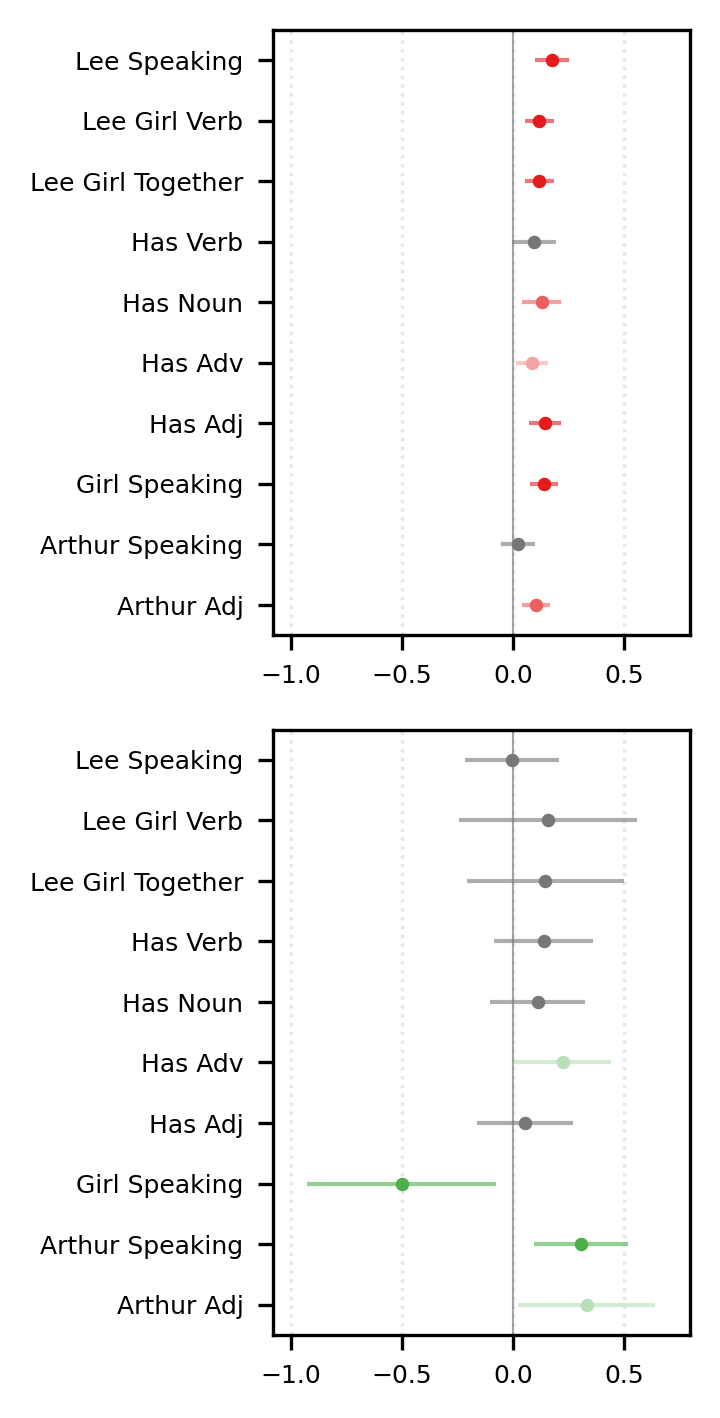

In [48]:
plot_brain_state_effects(main_analysis_a0p1, use_cohens_d=False, save_path='glmm_treeplot_a0p1', figsize=(2.5, 5), label=True)

['arthur_adj', 'arthur_speaking', 'girl_speaking', 'has_adj', 'has_adv', 'has_noun', 'has_verb', 'lee_girl_together', 'lee_girl_verb', 'lee_speaking']


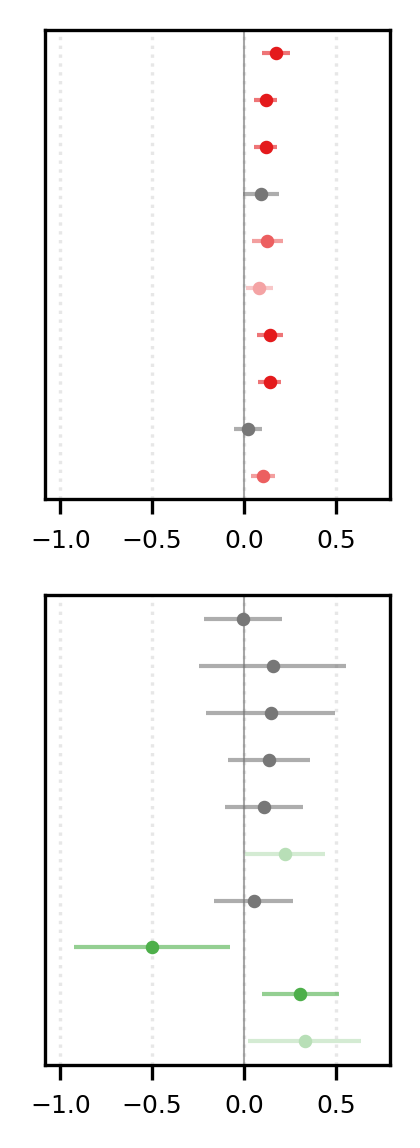

In [43]:
plot_brain_state_effects(main_analysis_a0p1, use_cohens_d=False, save_path='glmm_treeplot_a0p1', label=False)

['arthur_adj', 'arthur_speaking', 'girl_speaking', 'has_adj', 'has_adv', 'has_noun', 'has_verb', 'lee_girl_together', 'lee_girl_verb', 'lee_speaking']


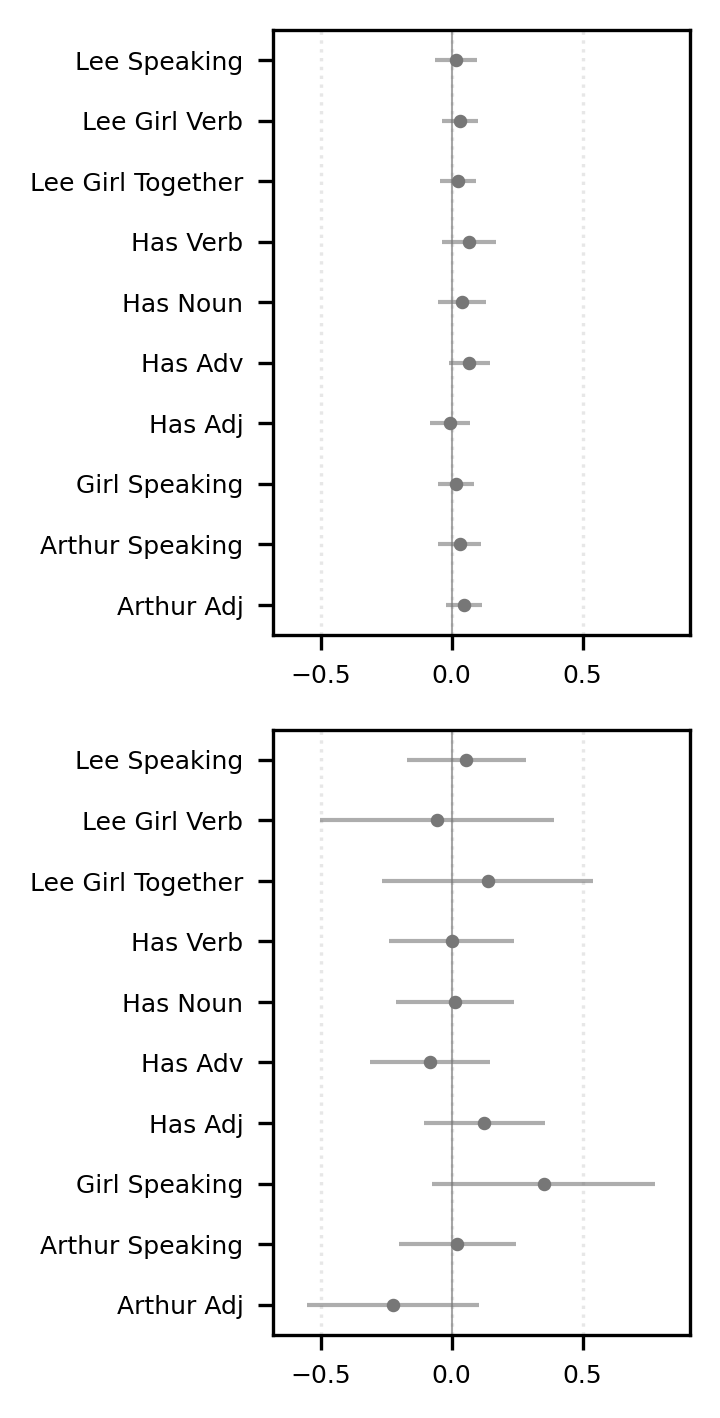

In [46]:
plot_brain_state_effects(main_analysis_a1p2, use_cohens_d=False, save_path='glmm_treeplot_a1p2', figsize=(2.5, 5), label=True)

['arthur_adj', 'arthur_speaking', 'girl_speaking', 'has_adj', 'has_adv', 'has_noun', 'has_verb', 'lee_girl_together', 'lee_girl_verb', 'lee_speaking']


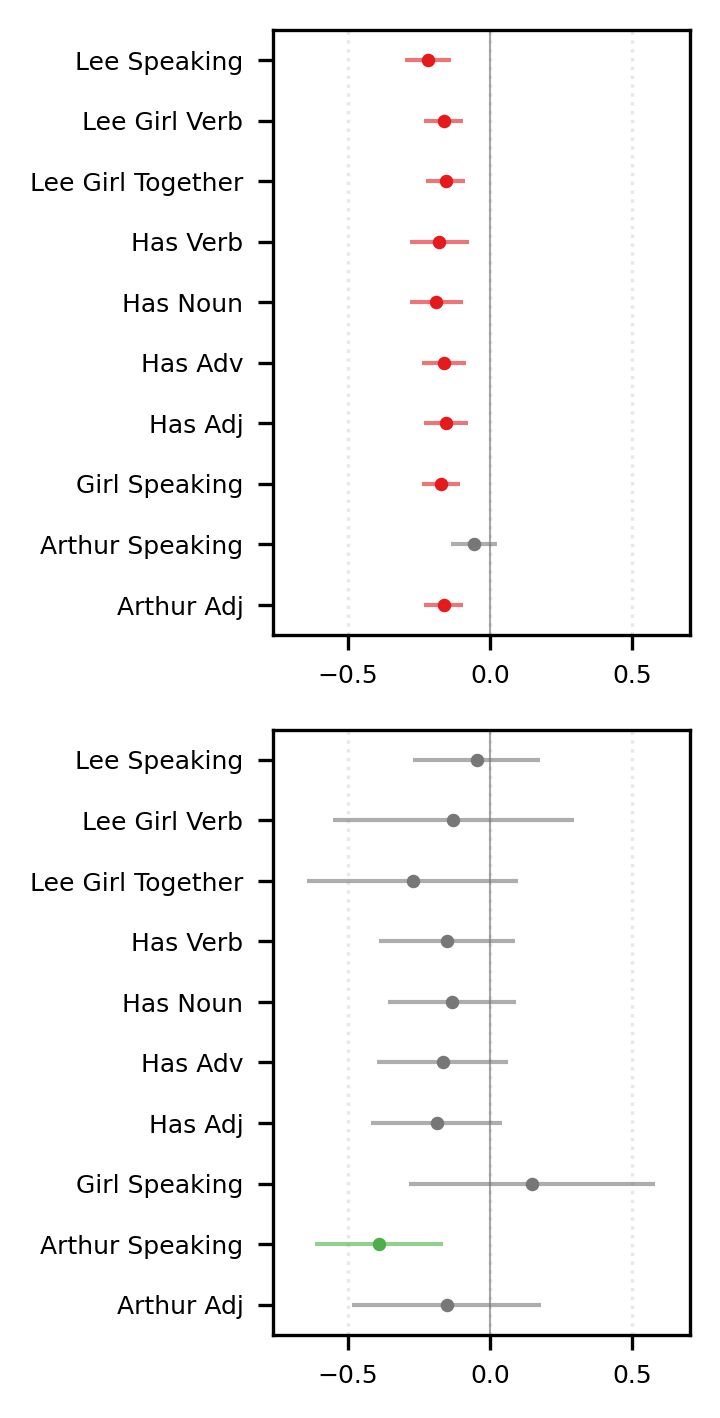

In [47]:
plot_brain_state_effects(main_analysis_a2p0, use_cohens_d=False, save_path='glmm_treeplot_a2p0', figsize=(2.5, 5), label=True)

## P3 - behavior-content analysis

In [49]:
behav_result_file = Path(OUTPUT_DIR) / '12_behavioral_analysis' / 'results.json'

In [50]:
def load_results(filename):
    """Load analysis results from JSON file"""
    with open(filename, 'r') as f:
        return json.load(f)

In [55]:
behav_results = load_results(behav_result_file)

In [92]:
def plot_behavioral_content_analysis(results, use_cohens_d=False, save_path=None, figsize=(1.5, 4), label=True):
    """Create figure showing content feature effects split by group
    
    Parameters:
    -----------
    results : dict
        Dictionary containing the analysis results
    use_cohens_d : bool
        If True, use standardized effect size as x-axis metric; if False, use log odds coefficients
    save_path : str, optional
        Path to save the figure
    figsize : tuple, optional
        Figure size (width, height)
    label : bool
        Whether to include feature labels on the y-axis
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure with behavioral content analysis
    """
    # Create figure with two subplots (rows instead of columns)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Define features
    features = ['has_adj', 'has_adv', 'has_noun', 'arthur_speaking',
                'girl_speaking', 'lee_speaking', 'has_verb', 'lee_girl_together',
                'lee_girl_verb', 'arthur_adj']
    
    # Sort features alphabetically
    plot_features = sorted(features)
    
    # Prepare data for Affair group
    affair_data = {
        'feature': plot_features
    }
    
    if use_cohens_d:
        # For standardized effect (if available in the results structure)
        if 'effect_sizes' in results:
            affair_data['effect'] = [results['effect_sizes'][f]['standardized_effect'] 
                                    for f in plot_features]
        else:
            # Approximate standardized effect from coefficients
            affair_data['effect'] = [results['content_relationships']['coefficients'][f] / 1.81 
                                    for f in plot_features]  # 1.81 is a standard logistic distribution SD
        x_label = "Effect Size (Standardized)"
    else:
        # For log odds coefficients
        affair_data['effect'] = [results['content_relationships']['coefficients'][f] 
                                for f in plot_features]
        x_label = "Log Odds"
    
    # Add credible intervals
    affair_data['ci_lower'] = [results['content_relationships']['confidence_intervals']['lower'][f] 
                              for f in plot_features]
    affair_data['ci_upper'] = [results['content_relationships']['confidence_intervals']['upper'][f] 
                              for f in plot_features]
    
    # Add posterior probability
    affair_data['probability'] = [1 - results['content_relationships']['prob_nonzero'][f] 
                                 for f in plot_features]  # Convert p-value to probability
    
    # Prepare data for Paranoia group (add interaction effects)
    paranoia_data = {
        'feature': plot_features
    }
    
    if use_cohens_d:
        # For standardized effect (if available)
        if 'effect_sizes' in results:
            paranoia_data['effect'] = [results['effect_sizes'][f]['standardized_effect'] * 
                                      (1 + results['content_relationships']['coefficients'][f'group_{f}_interaction'] / 
                                       results['content_relationships']['coefficients'][f])
                                      for f in plot_features]
        else:
            # Approximate standardized effect from combined coefficients
            paranoia_data['effect'] = [(results['content_relationships']['coefficients'][f] + 
                                       results['content_relationships']['coefficients'][f'group_{f}_interaction']) / 1.81 
                                      for f in plot_features]
    else:
        # For log odds coefficients
        paranoia_data['effect'] = [results['content_relationships']['coefficients'][f] +
                                  results['content_relationships']['coefficients'][f'group_{f}_interaction']
                                  for f in plot_features]
    
    # Add credible intervals for paranoia group
    paranoia_data['ci_lower'] = [results['content_relationships']['confidence_intervals']['lower'][f] +
                                results['content_relationships']['confidence_intervals']['lower'][f'group_{f}_interaction']
                                for f in plot_features]
    paranoia_data['ci_upper'] = [results['content_relationships']['confidence_intervals']['upper'][f] +
                                results['content_relationships']['confidence_intervals']['upper'][f'group_{f}_interaction']
                                for f in plot_features]
    
    # Add posterior probability for paranoia group
    paranoia_data['probability'] = [1 - results['content_relationships']['prob_nonzero'][f'group_{f}_interaction'] 
                                   for f in plot_features]
    
    # Convert to DataFrames
    df_affair = pd.DataFrame(affair_data)
    df_paranoia = pd.DataFrame(paranoia_data)
    
    # Define group colors
    affair_color = COLORS['affair']
    paranoia_color = COLORS['paranoia']
    
    # Helper function for color adjustment
    def adjust_color_alpha(color, alpha_factor):
        """Adjust the alpha/intensity of a color"""
        rgb = plt.cm.colors.ColorConverter.to_rgb(color)
        return tuple([c * alpha_factor + (1-alpha_factor) for c in rgb])
    
    # Function to plot one group
    def plot_group(ax, df, title, group_color, is_bottom=False, label=True):
        # Create color variants for probability levels
        color_high = group_color
        color_med = adjust_color_alpha(group_color, 0.7)
        color_low = adjust_color_alpha(group_color, 0.4)
        gray_color = '#777777'
        
        # Determine color based on posterior probability AND CI crossing zero
        colors = []
        for _, row in df.iterrows():
            # Check if CI crosses zero
            ci_crosses_zero = (row['ci_lower'] < 0 and row['ci_upper'] > 0)
            
            # Get the posterior probability
            prob = row['probability']
            
            # Assign color based on probability and CI
            if not ci_crosses_zero:
                if prob > 0.999:
                    colors.append(color_high)
                elif prob > 0.99:
                    colors.append(color_med)  
                elif prob > 0.95:
                    colors.append(color_low)
                else:
                    colors.append(gray_color)
            else:
                colors.append(gray_color)
        
        # Calculate y-positions
        y_pos = np.arange(len(df))
        
        # Find appropriate axis limits
        all_values = list(df['effect']) + list(df['ci_lower']) + list(df['ci_upper'])
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Add padding
        padding = 0.1 * (max_val - min_val)
        x_min = min_val - padding
        x_max = max_val + padding
        
        # Ensure zero is visible if it's close to the range
        if min_val > -padding and min_val < 0:
            x_min = -padding
        if max_val < padding and max_val > 0:
            x_max = padding
            
        # Plot reference line at zero
        ax.axvline(x=0, color='gray', linestyle='-', alpha=0.7, linewidth=0.5)
        
        # # Add reference lines for effect sizes
        # if not use_cohens_d:
        #     effects = [-2, -1, -0.5, 0.5, 1, 2]
        #     for effect in effects:
        #         ax.axvline(x=effect, color='gray', alpha=0.2, linestyle=':')
                # # Add OR values above the plot
                # if is_bottom:  # Only add labels to bottom plot
                #     ax.text(effect, len(df) + 0.3, f"OR={np.exp(effect):.1f}", 
                #            ha='center', va='bottom', alpha=0.6)
        
        # Plot data points and intervals
        for i, (_, row) in enumerate(df.iterrows()):
            # Plot CI line
            ax.hlines(y=y_pos[i], xmin=row['ci_lower'], xmax=row['ci_upper'], 
                     color=colors[i], alpha=0.6, linewidth=2)
            
            # Plot point
            ax.scatter(row['effect'], y_pos[i], color=colors[i], s=5, zorder=3)
        
        if is_bottom:
            ax.set_xlabel(x_label)
        else:
            ax.set_xlabel("")

        # Configure axis labels and ticks
        if label:
            ax.set_yticks(y_pos)
            ax.set_yticklabels([f.replace('_', ' ').title() for f in plot_features])
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.set_xlabel("")

        
        
        ax.set_title(title)
        
        # Set axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(-0.5, len(df) - 0.5)
        
        # Add grid
        ax.grid(axis='x', linestyle=':', alpha=0.3)
        
        # Add legend with only elements that appear in the plot
        from matplotlib.lines import Line2D
        
        # Create sets to track which probability levels are used
        has_high_prob = any(c == color_high for c in colors)
        has_med_prob = any(c == color_med for c in colors)
        has_low_prob = any(c == color_low for c in colors)
        has_gray = any(c == gray_color for c in colors)
        
        # Only include legend elements that are present in the plot
        legend_elements = []
        if has_high_prob:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color_high,
                                label='>99.9% probability', markersize=8))
        if has_med_prob:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color_med,
                                label='>99% probability', markersize=8))
        if has_low_prob:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color_low,
                                label='>95% probability', markersize=8))
        if has_gray:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=gray_color,
                                label='<95% probability or CI crosses 0', markersize=8))
        
        # # Only add legend if there are elements to show
        # if legend_elements:
        #     ax.legend(handles=legend_elements, loc='best', fontsize=8)
    
    # Calculate global min and max for consistent x-axis scaling
    all_affair_values = list(df_affair['effect']) + list(df_affair['ci_lower']) + list(df_affair['ci_upper'])
    all_paranoia_values = list(df_paranoia['effect']) + list(df_paranoia['ci_lower']) + list(df_paranoia['ci_upper'])
    all_values = all_affair_values + all_paranoia_values
    
    global_min = min(all_values)
    global_max = max(all_values)
    
    # Add padding
    padding = 0.1 * (global_max - global_min)
    global_x_min = global_min - padding
    global_x_max = global_max + padding
    
    # Ensure zero is visible if it's close to the range
    if global_min > -padding and global_min < 0:
        global_x_min = -padding
    if global_max < padding and global_max > 0:
        global_x_max = padding

    # Plot both groups
    plot_group(ax1, df_affair, '', affair_color, is_bottom=False, label=label)
    plot_group(ax2, df_paranoia, '', paranoia_color, is_bottom=True, label=label)
    
    # Set the same x-axis limits for both plots
    ax1.set_xlim(global_x_min, global_x_max)
    ax2.set_xlim(global_x_min, global_x_max)
    
    # Set y-axis limits
    ax1.set_ylim(-0.5, len(df_affair) - 0.5)
    ax2.set_ylim(-0.5, len(df_paranoia) - 0.5)
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        if label:
            plt.savefig(SAVE_DIR_FIG4 / f'{save_path}_label.png', dpi=300, bbox_inches='tight')
            plt.savefig(SAVE_DIR_FIG4 / f'{save_path}_label.svg', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(f'{save_path}_nolabel.png', dpi=300, bbox_inches='tight')
            plt.savefig(f'{save_path}_nolabel.svg', dpi=300, bbox_inches='tight')
    
    return fig

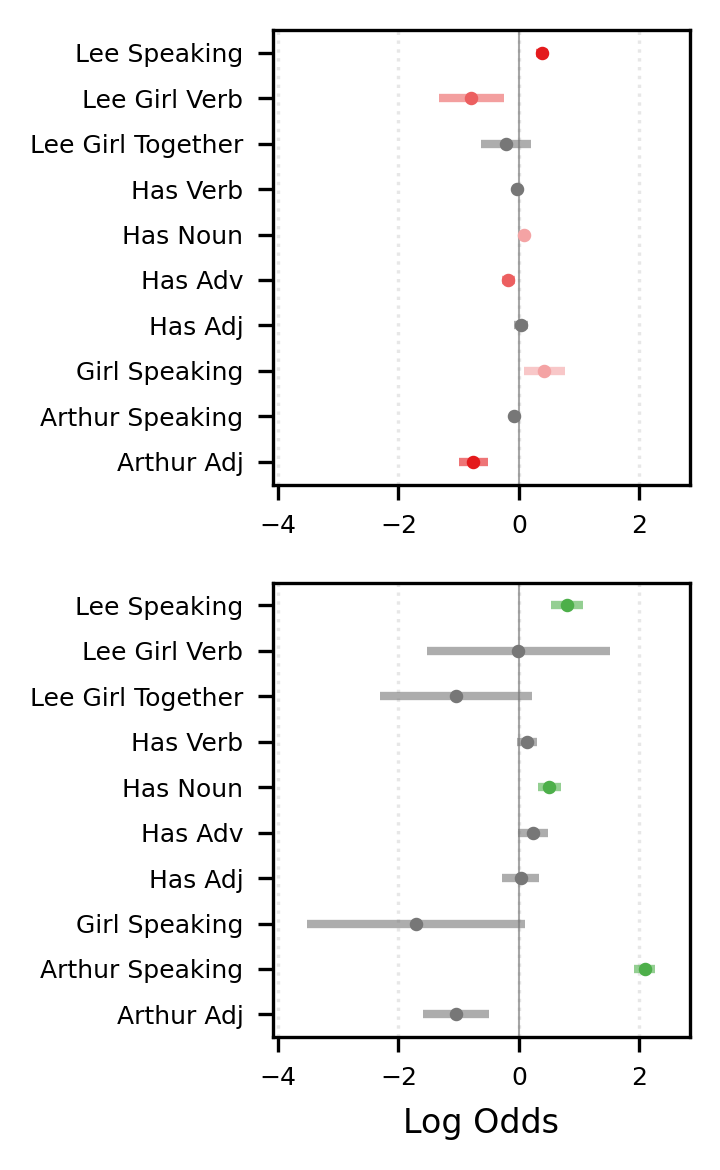

In [93]:
plot_behavioral_content_analysis(behav_results, use_cohens_d=False, save_path='behavioral_content_analysis', figsize=(2.5, 4), label=True)

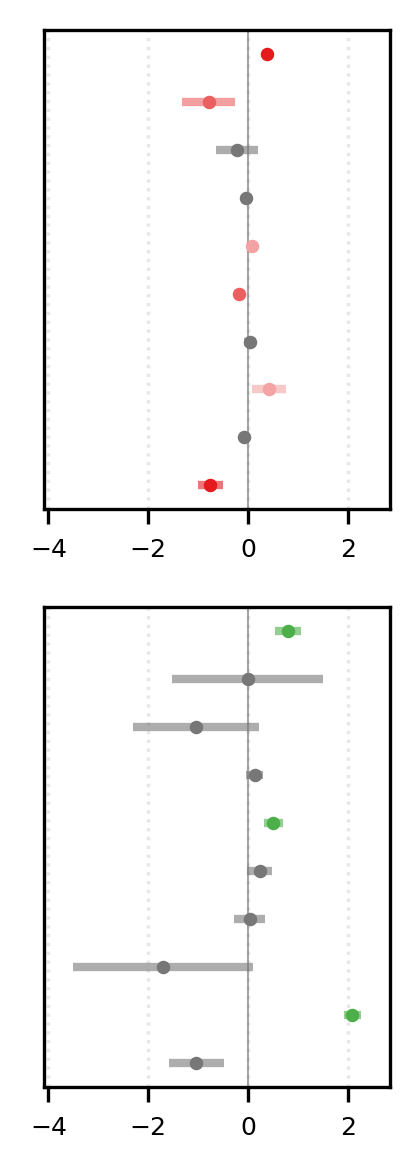

In [94]:
plot_behavioral_content_analysis(behav_results, use_cohens_d=False, save_path='behavioral_content_analysis', figsize=(1.5, 4), label=False)